# Exploratory Data Analysis

This notebook explores the dataset to find trends and effects which might impact modelling decisions and help evaluate output.

##1. Dependencies

In [13]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.stats import poisson
import matplotlib.pyplot as plt

# Data
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/Goal_Prediction_Model/data/league_one_and_two_data.csv")
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,start,home_team_id,home_team_name,competition_id,season_id,competition_name,away_team_id,away_team_name,home_score,away_score,home_xg,away_xg,features_neutral_venue,features_no_crowds
0,1713,2017-08-12 16:00:00+00:00,71,AFC Wimbledon,3,1,League One,69,Shrewsbury Town,0,1,0.258691,1.166972,False,False
1,1716,2017-08-12 16:00:00+00:00,87,Bristol Rovers,3,1,League One,78,Peterborough United,1,4,2.123095,3.151059,False,False
2,1761,2017-08-19 16:00:00+00:00,81,Fleetwood Town,3,1,League One,71,AFC Wimbledon,2,0,0.217756,1.468496,False,False
3,1760,2017-08-19 16:00:00+00:00,88,Southend United,3,1,League One,90,Plymouth Argyle,1,1,1.131817,0.598636,False,False
4,1757,2017-08-19 16:00:00+00:00,91,Scunthorpe United,3,1,League One,80,Oxford United,1,0,1.038351,1.076372,False,False
5,1756,2017-08-19 16:00:00+00:00,78,Peterborough United,3,1,League One,86,Rotherham United,2,1,1.955395,1.670014,False,False
6,1753,2017-08-19 16:00:00+00:00,73,Portsmouth,3,1,League One,79,Walsall,1,1,0.710397,1.434023,False,False
7,1755,2017-08-19 16:00:00+00:00,70,Doncaster Rovers,3,1,League One,82,Blackpool,3,3,1.803022,0.630519,False,False
8,1751,2017-08-19 16:00:00+00:00,84,Oldham Athletic,3,1,League One,85,Wigan Athletic,0,2,0.705178,1.055413,False,False
9,1750,2017-08-19 16:00:00+00:00,89,Milton Keynes Dons,3,1,League One,74,Gillingham,1,0,2.034986,0.357925,False,False


##2. Missing Data

The first step checks for missing data and values:

In [14]:
# Checking for missing values
print(f"There are {df.isnull().sum().sum()} missing values in the dataset")

There are 0 missing values in the dataset


There are no missing values but there may be missing matches. Full League 1 and League 2 seasons should contain 557 matches (552 regular games + 5 playoff matches).

In [15]:
fixtures = pd.crosstab(df['season_id'], df['competition_name'])
print(fixtures)

competition_name  League One  League Two
season_id                               
1                        518           0
4                        543         533
42                       402         441
90                       555         550
108                      557         556
235                      557         556
281                      556         556
317                      557         555
318                       71          68


Ignoring the season_id 42, which was interrupted for Covid, and one completely missing League 2 season, there are some missing matches, although most seasons are mostly complete. Small amounts of missing matches should not affect predictive models as long as the missing data is uncorrelated.

In [16]:
# Checking for duplicates
print(f"There are {df.duplicated().sum()} duplicated matches.")

# Checking for non-randomness in missig matches
teams = pd.concat([df[["season_id", "competition_id", "home_team_name"]].rename(columns={"home_team_name": "team"}),
                  df[["season_id", "competition_id", "away_team_name"]].rename(columns={"away_team_name": "team"})])

# Remove Covid and current season which will have a lot of missing matches
teams = teams[~teams["season_id"].isin([42, 318])]

team_matches = (teams.groupby(["season_id", "competition_id", "team"]).size().reset_index(name="total_games"))
print(f"The fewest number of games observed for a team in a single season is {team_matches['total_games'].min()}.")
print(f"{len(team_matches.loc[team_matches['total_games'] > 49])} teams have played more than 49 games in a season.")

There are 0 duplicated matches.
The fewest number of games observed for a team in a single season is 40.
0 teams have played more than 49 games in a season.


From this quick check we can see that the most amount of missing matches for a single team in a season is 6. Also, no teams are incorrectly down as having played over 49 league games and no matches are duplicated.

##3.  Goal Distribution

Traditionally, goals in football have been modelled using Poisson distributions. The plot below illustrates that the Poisson distribution is also a good fit for this dataset, and can be applied to home and away goals independenlty:

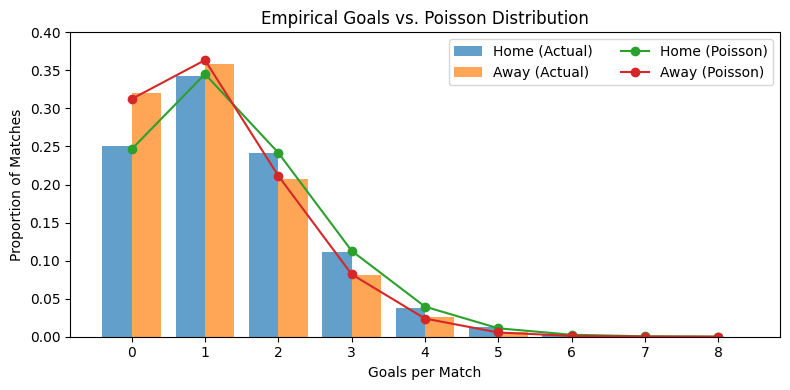

In [17]:
max_goals = 8
n = np.arange(0, max_goals + 1)

# Mean values form the data
mu_home = df["home_score"].mean()
mu_away = df["away_score"].mean()

# Poisson pmfs
pmf_home = poisson.pmf(n, mu_home)
pmf_away = poisson.pmf(n, mu_away)
bins = np.arange(-0.5, max_goals + 1.5, 1)

# Histogram of observed goals divided by home and away
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist([df["home_score"].values, df["away_score"].values],bins=bins,density=True,alpha=0.7,label=["Home (Actual)", "Away (Actual)"])

# Overlay Poisson pmf lines
ax.plot(n, pmf_home, marker="o", linestyle="-", label="Home (Poisson)")
ax.plot(n, pmf_away, marker="o", linestyle="-", label="Away (Poisson)")
ax.set_xticks(n)
ax.set_xlabel("Goals per Match")
ax.set_ylabel("Proportion of Matches")
ax.set_title("Empirical Goals vs. Poisson Distribution")
ax.set_ylim(0, max(0.4, float(max(pmf_home.max(), pmf_away.max())) * 1.1))
ax.legend(ncol=2)
plt.tight_layout()
plt.show()


##4. Goal Trends

To build models which can accurately model total goals in future matches, a good understanding of which factors impact goal rates is important. This section epxlores some trends

###4.1 Tmemporal Goal Trends

Has the rate of goal scoring changed over the 9 seasons in the dataset?

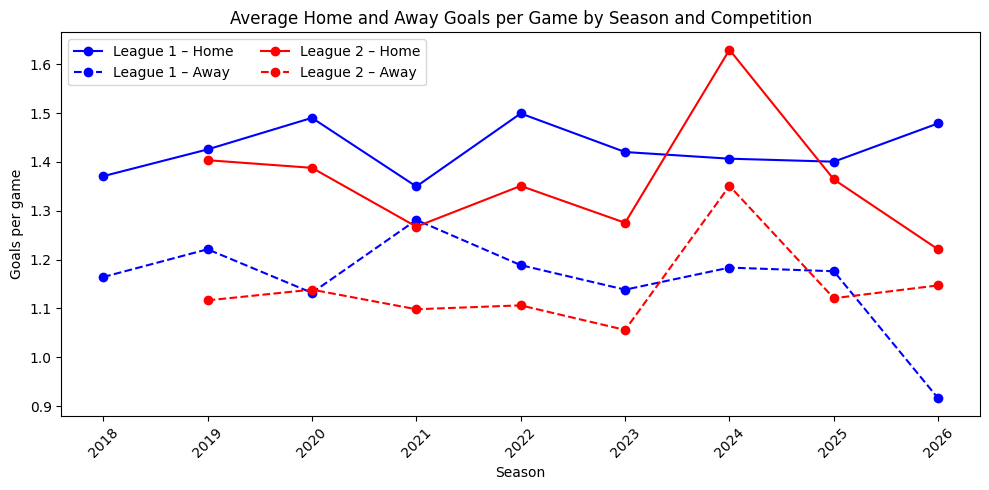

In [18]:
seasons_map = {1:2018, 4:2019, 42:2020, 90:2021, 108:2022, 235:2023, 281:2024, 317:2025, 318:2026}
df['season'] = df['season_id'].map(seasons_map)
df['league'] = df['competition_name'].apply(lambda x: 1 if x == 'League One' else 2)

season_goals = (df.groupby(["season", "league"]).agg(home_goals_pg=("home_score", "mean"),away_goals_pg=("away_score", "mean")).reset_index())
season_order = sorted(season_goals["season"].unique())
season_goals["season_cat"] = pd.Categorical(season_goals["season"],categories=season_order,ordered=True)
x_pos = {season: i for i, season in enumerate(season_order)}
plt.figure(figsize=(10, 5))

for league, g in season_goals.groupby("league"):
    x = g["season"].map(x_pos)
    if league == 1:
      plt.plot(x,g["home_goals_pg"],marker="o",linestyle="-",label=f"League {league} – Home", color="blue")
      plt.plot(x,g["away_goals_pg"],marker="o",linestyle="--",label=f"League {league} – Away", color="blue")
    else:
      plt.plot(x,g["home_goals_pg"],marker="o",linestyle="-",label=f"League {league} – Home", color="red")
      plt.plot(x,g["away_goals_pg"],marker="o",linestyle="--",label=f"League {league} – Away", color="red")

plt.xticks(ticks=range(len(season_order)),labels=season_order,rotation=45)
plt.xlabel("Season")
plt.ylabel("Goals per game")
plt.title("Average Home and Away Goals per Game by Season and Competition")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

There is no apparent trend in goal rates over the last 9 seasons. Goals have been scored at consistent rates of around 1.45 for home teams and 1.2 for away teams.

Do goal rates changes over the course of a season?

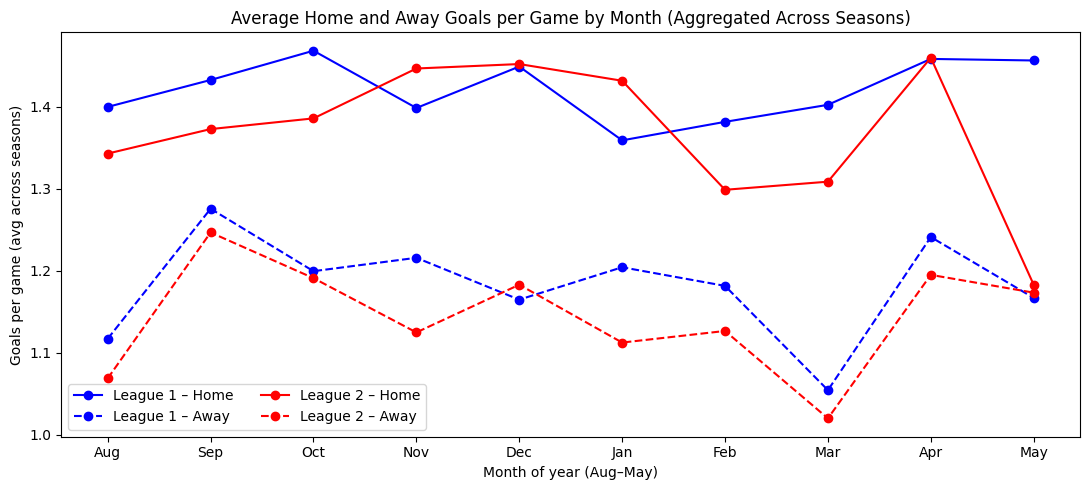

In [19]:
df_plot = df.copy()
df_plot["start"] = pd.to_datetime(df_plot["start"], utc=True, errors="coerce")
df_plot = df_plot.dropna(subset=["start"])
df_plot["month"] = df_plot["start"].dt.month
month_order = [8, 9, 10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ["Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May"]

df_plot = df_plot[df_plot["month"].isin(month_order)]
monthly_goals = (df_plot.groupby(["league", "month"]).agg(home_goals_pg=("home_score", "mean"),away_goals_pg=("away_score", "mean")).reset_index())
x_pos = {m: i for i, m in enumerate(month_order)}

plt.figure(figsize=(11, 5))
for league, g in monthly_goals.groupby("league"):
    g = g.copy()
    g["x"] = g["month"].map(x_pos)
    g = g.sort_values("x")
    if league == 1:
      plt.plot(g["x"], g["home_goals_pg"], marker="o", linestyle="-",label=f"League {league} – Home", color="blue")
      plt.plot(g["x"], g["away_goals_pg"], marker="o", linestyle="--",label=f"League {league} – Away", color="blue")
    else:
      plt.plot(g["x"], g["home_goals_pg"], marker="o", linestyle="-",label=f"League {league} – Home", color="red")
      plt.plot(g["x"], g["away_goals_pg"], marker="o", linestyle="--",label=f"League {league} – Away", color="red")

plt.xticks(ticks=range(len(month_order)), labels=month_labels)
plt.xlabel("Month of year (Aug–May)")
plt.ylabel("Goals per game (avg across seasons)")
plt.title("Average Home and Away Goals per Game by Month (Aggregated Across Seasons)")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


There is no clear trend in goal scoring rates across the course of a season although it is interesting the pattern in away goals is similar for both Legaue 1 and 2.

### 4.2 Promotion and Relegation Effects

It is intuitive that newly promoted and relegated teams may score and concede goals at different rates to each other and to teams that stay stationary in the same league.

In [20]:
# Imoorting the pre-prepared data from data_preparation.csv which has promotion/relegation tags
model_df = pd.read_csv("/content/drive/My Drive/Goal_Prediction_Model/data/prepared_data.csv")

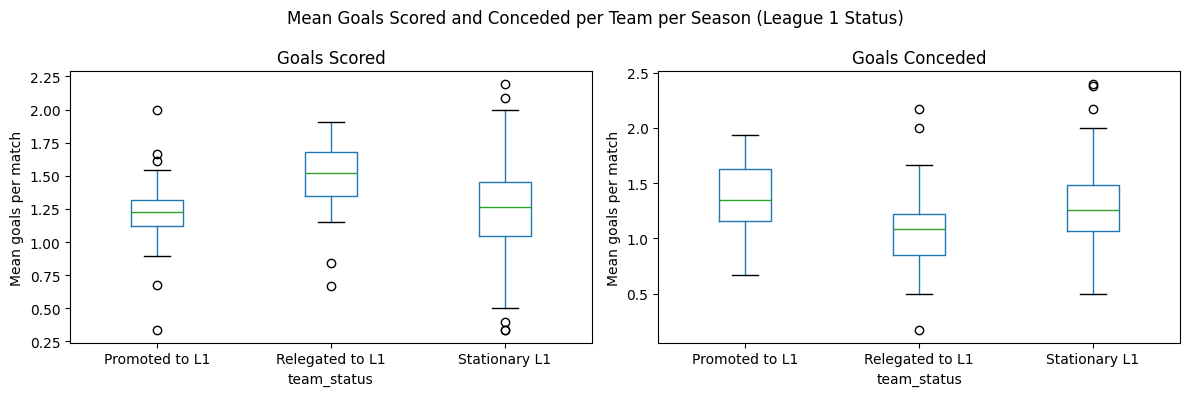

In [21]:
att = model_df.copy()
att["team_status"] = "Stationary L1"
att.loc[att["att_pro_L1"], "team_status"] = "Promoted to L1"
att.loc[att["att_rel_L1"], "team_status"] = "Relegated to L1"
att_team_season = (att.groupby(["season", "attack_id", "team_status"], as_index=False)
                .agg(mean_goals_scored=("goals", "mean"), games=("goals", "size")))

deff = model_df.copy()
deff["team_status"] = "Stationary L1"
deff.loc[deff["def_pro_L1"], "team_status"] = "Promoted to L1"
deff.loc[deff["def_rel_L1"], "team_status"] = "Relegated to L1"
def_team_season = (deff.groupby(["season", "defence_id", "team_status"], as_index=False)
                .agg(mean_goals_conceded=("goals", "mean"), games=("goals", "size")))


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

att_team_season.boxplot(column="mean_goals_scored",by="team_status",grid=False,ax=axes[0])
axes[0].set_title("Goals Scored")
axes[0].set_ylabel("Mean goals per match")

def_team_season.boxplot(column="mean_goals_conceded",by="team_status",grid=False,ax=axes[1])
axes[1].set_title("Goals Conceded")
axes[1].set_ylabel("Mean goals per match")

fig.suptitle("Mean Goals Scored and Conceded per Team per Season (League 1 Status)")
plt.tight_layout()
plt.show()


Looking at League 1, it is clear that the average team relegated from the Championship scores at a higher rate and concedes at a lower rate than other teams, on average. Teams newly promoted to League 1 tend to score less and concede more than other teams.

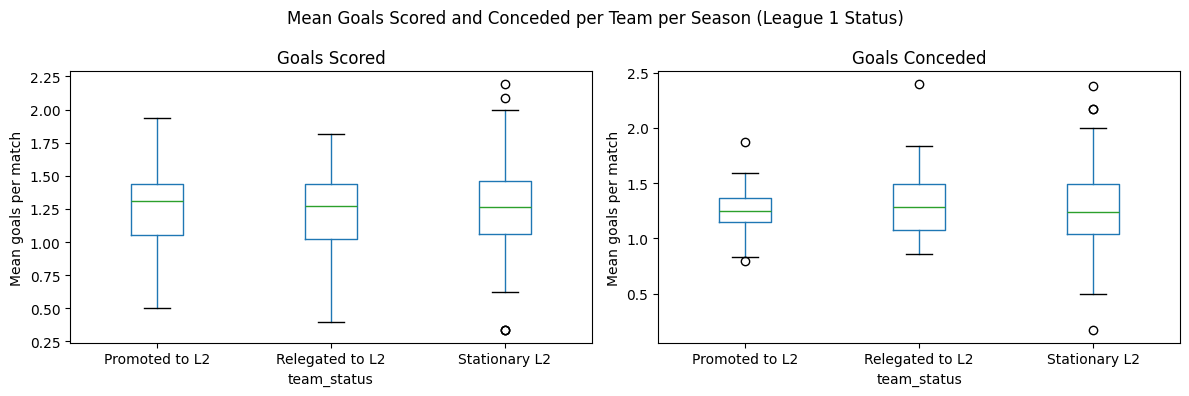

In [22]:
att = model_df.copy()
att["team_status"] = "Stationary L2"
att.loc[att["att_pro_L2"], "team_status"] = "Promoted to L2"
att.loc[att["att_rel_L2"], "team_status"] = "Relegated to L2"
att_team_season = (att.groupby(["season", "attack_id", "team_status"], as_index=False)
                .agg(mean_goals_scored=("goals", "mean"), games=("goals", "size")))

deff = model_df.copy()
deff["team_status"] = "Stationary L2"
deff.loc[deff["def_pro_L2"], "team_status"] = "Promoted to L2"
deff.loc[deff["def_rel_L2"], "team_status"] = "Relegated to L2"
def_team_season = (deff.groupby(["season", "defence_id", "team_status"], as_index=False)
                .agg(mean_goals_conceded=("goals", "mean"), games=("goals", "size")))


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

att_team_season.boxplot(column="mean_goals_scored",by="team_status",grid=False,ax=axes[0])
axes[0].set_title("Goals Scored")
axes[0].set_ylabel("Mean goals per match")

def_team_season.boxplot(column="mean_goals_conceded",by="team_status",grid=False,ax=axes[1])
axes[1].set_title("Goals Conceded")
axes[1].set_ylabel("Mean goals per match")

fig.suptitle("Mean Goals Scored and Conceded per Team per Season (League 1 Status)")
plt.tight_layout()
plt.show()

The clear promotion and relegation effects are less observable in League 2 where there are no clear differences between promoted, relegated and stationary teams in term of scoring and conceding rates.